In [1]:
import math
import numpy as np
import pandas as pd

import re
import time

np.random.seed(1)

from matplotlib import pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
train = pd.read_csv("./data/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("./data/test.csv", dtype={"Age": np.float64}, )

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# view some basic statistics about the training data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# analyze for null values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df_analysis = train.copy()

Text(0, 0.5, '')

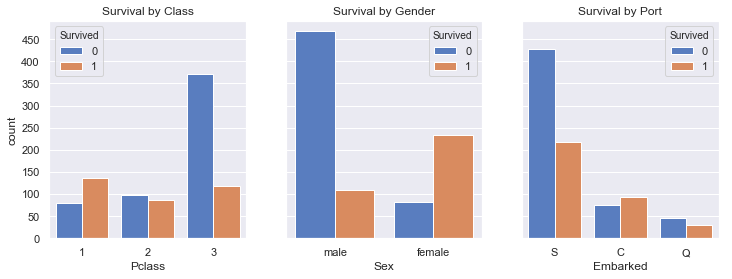

In [8]:
sns.set()
sns.set_palette("muted")

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))

sns.countplot(x="Pclass", hue="Survived", data=df_analysis, ax=ax[0])
ax[0].set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
ax[0].set_title('Survival by Class')

sns.countplot(x="Sex", hue="Survived", data=df_analysis, ax=ax[1])
ax[1].set_title('Survival by Gender')
ax[1].set_ylabel('')

sns.countplot(x="Embarked", hue="Survived", data=df_analysis, ax=ax[2])
ax[2].set_title('Survival by Port')
ax[2].set_ylabel('')

In [9]:
# get dataset for analysis of ages
df_analysis = train.copy()
df_analysis = df_analysis[['Survived', 'Sex', 'Age']]

# split ages into groups
df_analysis['AgeGroup'] = pd.cut(df_analysis['Age'].fillna(-1), bins=(-10, 0, 10, 20, 55, 150), labels=['unknown','child','teen','adult','senior'])
df_analysis.head()

,Survived,Sex,Age,AgeGroup
0,0,male,22.0,adult
1,1,female,38.0,adult
2,1,female,26.0,adult
3,1,female,35.0,adult
4,0,male,35.0,adult


C:\Users\ismael\Anaconda3\envs\curso_gpu\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\ismael\Anaconda3\envs\curso_gpu\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


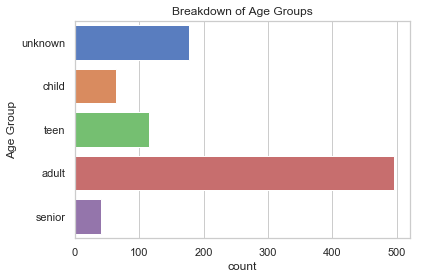

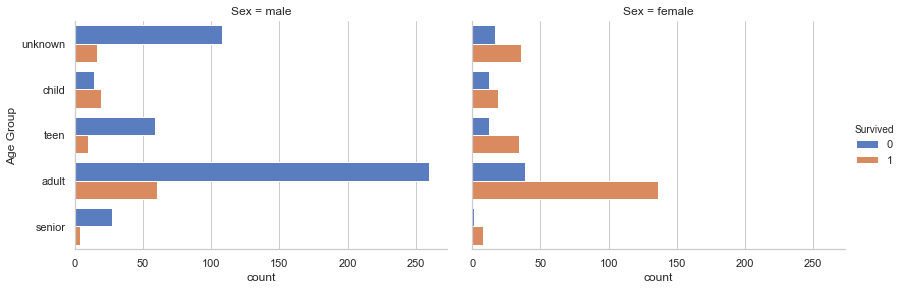

In [11]:
sns.set_style("whitegrid")

fig, ax = plt.subplots()

g = sns.countplot(y="AgeGroup", data=df_analysis, palette='muted', ax=ax)
ax.set_title('Breakdown of Age Groups')
ax.set_ylabel('Age Group')

g = sns.factorplot(y="AgeGroup", hue="Survived", col="Sex", data=df_analysis, kind="count", size=4, aspect=1.5)
g.set_axis_labels("count", "Age Group")

In [12]:
df_analysis = train.copy()
df_analysis['Cabin'].str.extract('(?P<cabin>[A-Z])\d*', expand=True).fillna('NA').head()

,cabin
0,NA
1,C
2,NA
3,C
4,NA


In [13]:
# function to extract adjusted titles (with some grouped)
def get_adjusted_title(name):
    srch = re.search('([A-Za-z]+)\.', name)
    
    if srch == None:
        title = 'None'
    else:
        title = srch.groups(0)[0]
        
    if title in ['Mr', 'Mrs', 'Miss', 'Ms', 'Mme', 'Mlle']:
        title = 'Gender'
    elif title in ['Master']:
        title = 'Master'
    elif title in ['Don', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer']:
        title = "Rare"
    else:
        title = "Other"
        
    return title

In [14]:
# this preprocesses the data in a format that is human-friendly so that I can inspect it
def preprocessData(data):
    x = data.copy()
    
    # break Fare into groups
    x['FareGroup'] = pd.cut(x['Fare'].fillna(-1), bins=[-1, 8, 14.5, 31, 1000]).cat.codes
          
    # encode Sex
    x['Sex'] = x['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
      
    # extract title from name and break into groups
    x['TitleGroup'] = x['Name'].apply(lambda n: get_adjusted_title(n))
    
    # break Age into groups
    x['Age'].fillna(0, inplace=True)
    x["AgeGroup"] = pd.cut(x['Age'].fillna(-1), bins=[-10, 0, 10, 20, 55, 150], labels=['unknown','child','teen','adult','senior'])
          
    # extract Cabin letter
    x['Cabin-Letter'] = x['Cabin'].str.extract('(?P<cabin>[A-Z])\d*', expand=True).fillna('NA')
    x['HasCabin'] = x['Cabin-Letter'] != 'NA'
    
    # Embarked
    x['Embarked'].fillna('UNK', inplace=True)
    
    # family size
    x['FamilySize'] = x['SibSp'] + x['Parch']
    x['IsAlone'] = x['FamilySize'] == 0
    
    if 'Survived' in data.columns:
        y = data['Survived']
    else:
        y = None
    
    return x, y



In [15]:
# this preprocesses the data in a format that is better to feed to a neural network 
def preprocessDataForModel(data):
    
    x, y = preprocessData(data)
    
    def oneHotEncode(dataSet, encodedColumn, validValues, prefix):
        for val in validValues:
            dataSet["{0}_{1}".format(prefix,val)] = (val == dataSet[encodedColumn]).astype(int)
    
    x['IsAlone'] = x['IsAlone'].astype(int)
    #x['HasCabin'] = x['HasCabin'].astype(int)
    
    oneHotEncode(x, 'FareGroup', validValues=range(4), prefix='f')
    oneHotEncode(x, 'AgeGroup', validValues=['unknown','child','teen','adult','senior'], prefix='a')
    oneHotEncode(x, 'TitleGroup', validValues=['Master','Rare','Other'], prefix='t')
    oneHotEncode(x, 'Embarked', validValues=['S','C','Q'], prefix='e')
    
    x = x.drop(columns=['Name','Age','AgeGroup','Cabin','Cabin-Letter','HasCabin','SibSp','Parch','Ticket','TitleGroup','Fare','FareGroup','Embarked'])
    if 'Survived' in x.columns:
        x = x.drop(columns=['Survived'])
    
    x = x.set_index('PassengerId')
    
    return x, y


In [16]:
# plot results of training (we'll use this after training the model)
def displayModelHistory(model_history):
    graph_history = model_history
    
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Training - Accuracy and Loss', fontsize=12)

    plt.subplot(121)
    line1, = plt.plot(range(1, len(graph_history['acc'])+1), graph_history['acc'], label='training')
    line2, = plt.plot(range(1, len(graph_history['val_acc'])+1), graph_history['val_acc'], label='validation')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(handles=[line1, line2])
    plt.grid(True)

    plt.subplot(122)
    line1, = plt.plot(range(1, len(graph_history['loss'])+1), graph_history['loss'], label='training')
    line2, = plt.plot(range(1, len(graph_history['val_loss'])+1), graph_history['val_loss'], label='validation')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(handles=[line1, line2])
    plt.grid(True)

In [17]:
# human friendly data
x_temp, _ = preprocessData(train)

# NN friendly data
x_train, y_train = preprocessDataForModel(train)
x_test, _ = preprocessDataForModel(test)

assert len(x_train.columns) == len(x_test.columns), 'Number of columns in x_train and x_test do not match'

# displaying the more human-readable format.  The one-hot encoded data will be fed to the NN
features = ['PassengerId','Survived','Pclass','Sex','Embarked','FareGroup','TitleGroup','AgeGroup','HasCabin','FamilySize','IsAlone']
x_temp = x_temp[features]
x_temp.head()

,PassengerId,Survived,Pclass,Sex,Embarked,FareGroup,TitleGroup,AgeGroup,HasCabin,FamilySize,IsAlone
0,1,0,3,1,S,0,Gender,adult,False,1,False
1,2,1,1,0,C,3,Gender,adult,True,1,False
2,3,1,3,0,S,0,Gender,adult,False,0,True
3,4,1,1,0,S,3,Gender,adult,True,1,False
4,5,0,3,1,S,1,Gender,adult,False,0,True


In [18]:
x_train.head()

,Pclass,Sex,FamilySize,IsAlone,f_0,f_1,f_2,f_3,a_unknown,a_child,a_teen,a_adult,a_senior,t_Master,t_Rare,t_Other,e_S,e_C,e_Q
PassengerId,,,,,,,,,,,,,,,,,,,
1,3,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,3,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
5,3,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [20]:
num_epochs = 40
batch_size = 32
models = []
log = []

# create and train 5 models
for i in range(5):
    
    # create model
    model = Sequential()

    model.add(Dense(25, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dropout(.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # fit/train model
    hist = model.fit(x=x_train, y=y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.3, verbose=0)

    log.append(hist.history)
    models.append(model)
    
    # evaluate model
    loss, acc = model.evaluate(x_train, y_train)
    print("loss: %s, accuracy: %s" % (loss, acc))

InternalError: Blas GEMM launch failed : a.shape=(32, 19), b.shape=(19, 25), m=32, n=25, k=19
	 [[{{node dense_4/MatMul}} = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/dense_4/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_4_input_0_0/_85, dense_4/kernel/read)]]